# Modelisation Fasttext et prétraitement stopWord/Stemming

## Librairies et fichiers

In [ ]:
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

Import des librairies

In [ ]:
!pip install fasttext

In [ ]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical

import fasttext

#from keras.models import Sequential
#from keras.models import load_model
#from keras.layers import Embedding, GRU, Dense
#from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from keras.layers import Dropout
#from keras.regularizers import l1_l2

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Pour les performances de classification

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go

output_path = "output/data-modeling-text-5-Fasttext/"

In [ ]:
# Catégories pour visu matrice
prdcodetype2label = {
    10 : "Livre occasion",
    40 : "Jeu vidéo, accessoire tech.",
    50 : "Accessoire Console",
    60 : "Console de jeu",
    1140 : "Figurine",
    1160 : "Carte Collection",
    1180 : "Jeu Plateau",
    1280 : "Jouet enfant, déguisement",
    1281 : "Jeu de société",
    1300 : "Jouet tech",
    1301 : "Paire de chaussettes",
    1302 : "Jeu extérieur, vêtement",
    1320 : "Autour du bébé",
    1560 : "Mobilier intérieur",
    1920 : "Chambre",
    1940 : "Cuisine",
    2060 : "Décoration intérieure",
    2220 : "Animal",
    2280 : "Revues et journaux",
    2403 : "Magazines, livres et BDs",
    2462 : "Jeu occasion",
    2522 : "Bureautique et papeterie",
    2582 : "Mobilier extérieur",
    2583 : "Autour de la piscine",
    2585 : "Bricolage",
    2705 : "Livre neuf",
    2905 : "Jeu PC",
}

## Préparation des données

### **Choix du type de texte en entrée (avec ou sans sens)**

**CHOIX 1:** Chargement du fichier source output/data-preprocessing-text-stopWord-steming


In [ ]:
df_train = pd.read_csv('output/data-preprocessing-text-stopWord-steming/X_train_trad.csv', index_col = 0)
display(df_train.head(2))
df_test = pd.read_csv('output/data-preprocessing-text-stopWord-steming/X_test_trad.csv', index_col = 0)
display(df_test.head(2))


,productid,imageid,text,lang,imagefile,prdtypecode,text_fr
0,131641431,885888766,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,fr,10/image_885888766_product_131641431.jpg,10,avenir autrement jesus prêtre cahiers libre
1,745789761,1304710852,The Inglorious Arts Of Peace: Exhibitions In C...,en,10/image_1304710852_product_745789761.jpg,10,canadienne sans xixe paix gloire exposition ar...


,productid,imageid,text,lang,imagefile,prdtypecode,text_fr
index,,,,,,,
29927,3469563513,1215209457,Adventure Parks Heavy Duty Tree Strap - Dont t...,en,1280/image_1215209457_product_3469563513.jpg,1280,attachez pouvez faire correctement balançoire ...
42596,4152889175,1309607798,Magideal 2 Pcs Orff Instrument De Musique Hoch...,fr,1320/image_1309607798_product_4152889175.jpg,1320,enfants cm stimuler développant orff accessoir...


**CHOIX 2:** Fichier contenant le texte nettoyé, mais avec le contexte (le sens)

In [ ]:
df_train = pd.read_csv('output/data-preprocessing-resampling/df_train.csv', index_col=0)
#display(df_train.head(2))
df_test = pd.read_csv('output/data-preprocessing-resampling/df_test.csv', index_col=0)
#display(df_test.head(2))

### Formattage

FastText s'attend à ce que les données d'entraînement et de test soient dans un format spécifique : chaque ligne du fichier doit contenir une liste de mots suivie par les étiquettes (labels) préfixées par __label__

In [ ]:
# Ajout du préfixe '__label__' à la colonne prdtypecode
df_train['label'] = df_train['prdtypecode'].apply(lambda x: '__label__' + str(x))
df_test['label'] = df_test['prdtypecode'].apply(lambda x: '__label__' + str(x))

# Concaténation du texte et du label
df_train['fasttext_data'] = df_train['label'] + ' ' + df_train['text_fr']
df_test['fasttext_data'] = df_test['label'] + ' ' + df_test['text_fr']

# Sauvegarde des données dans un format approprié pour FastText
train_file = os.path.join(output_path, "train.txt")
test_file = os.path.join(output_path, "test.txt")
df_train['fasttext_data'].to_csv(train_file, index=False, header=False)
df_test['fasttext_data'].to_csv(test_file, index=False, header=False)

In [ ]:
display(df_test.head(2))

,productid,imageid,text,lang,imagefile,prdtypecode,text_fr,label,fasttext_data
index,,,,,,,,,
29927,3469563513,1215209457,Adventure Parks Heavy Duty Tree Strap - Dont t...,en,1280/image_1215209457_product_3469563513.jpg,1280,attachez pouvez faire correctement balançoire ...,__label__1280,__label__1280 attachez pouvez faire correcteme...
42596,4152889175,1309607798,Magideal 2 Pcs Orff Instrument De Musique Hoch...,fr,1320/image_1309607798_product_4152889175.jpg,1320,enfants cm stimuler développant orff accessoir...,__label__1320,__label__1320 enfants cm stimuler développant ...


# **Entraînement du modèle**

**Configuration d'Entraînement FastText**

In [ ]:
# Paramètres
lr = 0.01  # Taux d'apprentissage
dim = 100  # Taille des vecteurs de mots
ws = 5    # Taille de la fenêtre de contexte
epoch = 400  # Nombre d'époques
minCount = 1  # Nombre minimal d'occurrences d'un mot pour être pris en compte
wordNgrams = 2  # Utilisation de n-grams de mots (bigrams dans ce cas)
loss = 'softmax'  # Fonction de perte (softmax est souvent utilisé pour la classification)
bucket = 2000000  # Nombre de buckets pour les n-grams de sous-mots

**Entraînement initial**

In [ ]:
model = fasttext.train_supervised(input = train_file, lr = lr, dim = dim, ws = ws, epoch = epoch,
                                  minCount = minCount, wordNgrams = wordNgrams, loss = loss, bucket = bucket)
# Sauvegarde du modèle
model_file = os.path.join(output_path, "model_fasttext_1.bin")
model.save_model(model_file)

## Évaluation

In [ ]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*model.test(test_file))

N	8491
P@1	0.798
R@1	0.798


In [ ]:
# Charger les données de test
#X_test = pd.read_csv(test_file, header=None, names=['data'])
#X_test['text'] = X_test['data'].apply(lambda x: ' '.join(x.split(' ')[1:]) if isinstance(x, str) else x)
X_test = pd.DataFrame()
X_test['text'] = df_test['text_fr']
# Nettoyer le texte en supprimant les caractères de retour à la ligne
X_test['text'] = X_test['text'].str.replace('\n', ' ')

y_test = df_test['prdtypecode']

# Obtenir les prédictions
y_pred = X_test['text'].apply(lambda x: model.predict(x)[0][0]if isinstance(x, str) else x)


In [ ]:
# Supprimer le préfixe __label__
y_pred = y_pred.apply(lambda x: x.replace('__label__', '') if isinstance(x, str) else x)

# Renommer la série
y_pred.name = 'prdtypecode'

# Convertir le type de données
y_pred = y_pred.astype('float')

In [ ]:
#y_test
y_test_visu = [prdcodetype2label.get(code, "Label") for code in y_test]

# y_pred
y_pred_visu = [prdcodetype2label.get(code, "Label") for code in y_pred]

Score du modèle : 0.7978097032501178


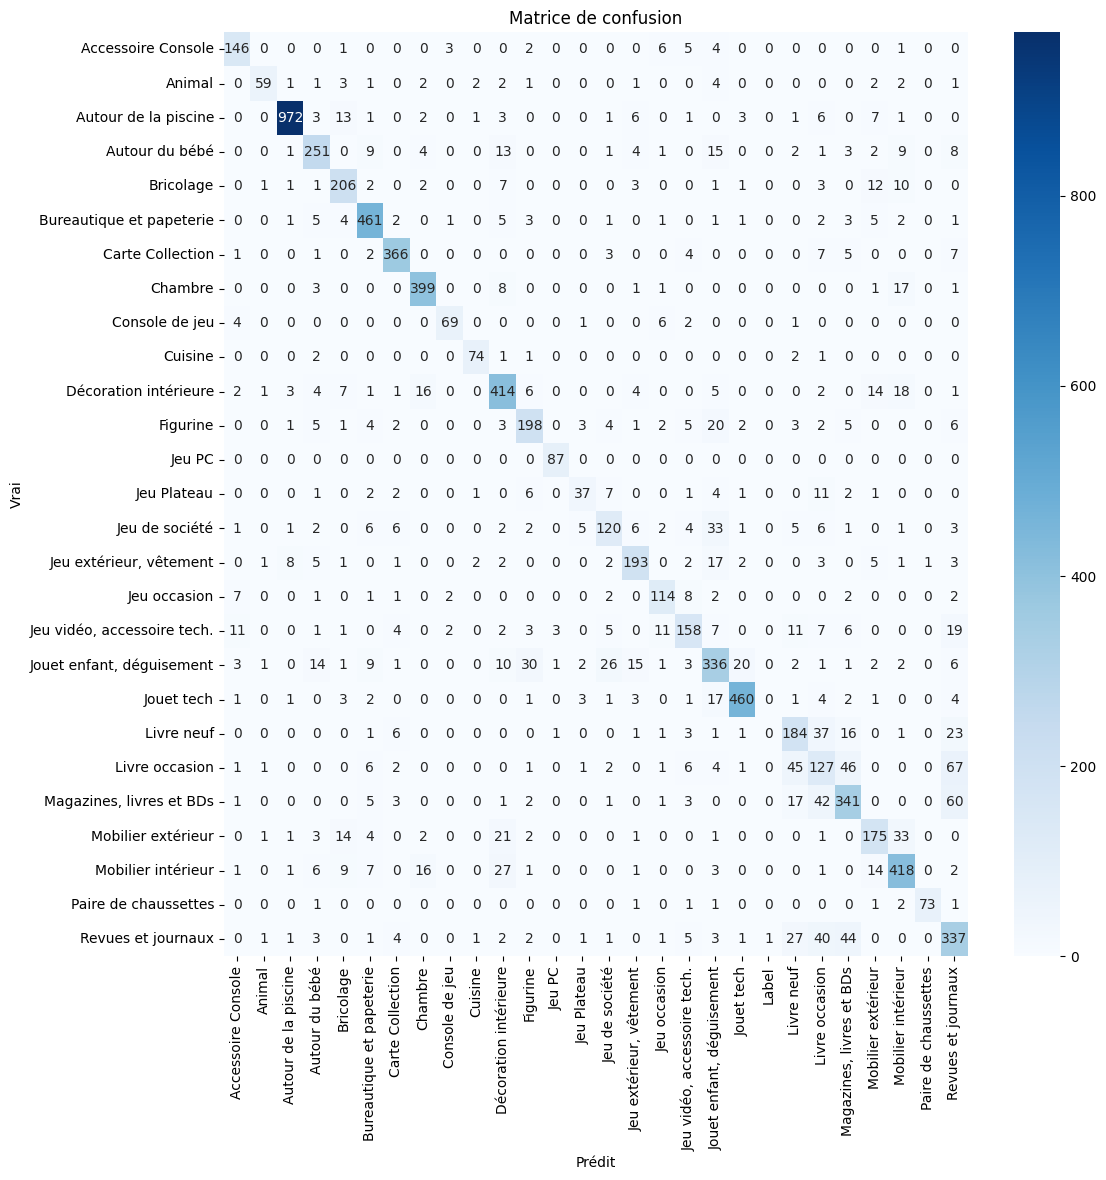

In [ ]:
# Calculer le score du modèle
score = accuracy_score(y_test_visu, y_pred_visu)
print("Score du modèle :", score)

# Créer et afficher la matrice de confusion
mat_conf = pd.crosstab(y_test_visu, y_pred_visu)

plt.figure(figsize=(12, 12))
sns.heatmap(mat_conf, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.show()

In [ ]:
print(classification_report(y_test_visu, y_pred_visu))

                             precision    recall  f1-score   support

         Accessoire Console       0.82      0.87      0.84       168
                     Animal       0.89      0.72      0.80        82
       Autour de la piscine       0.98      0.95      0.97      1021
             Autour du bébé       0.80      0.77      0.79       324
                  Bricolage       0.78      0.82      0.80       250
   Bureautique et papeterie       0.88      0.92      0.90       499
           Carte Collection       0.91      0.92      0.92       396
                    Chambre       0.90      0.93      0.91       431
             Console de jeu       0.90      0.83      0.86        83
                    Cuisine       0.91      0.91      0.91        81
      Décoration intérieure       0.79      0.83      0.81       499
                   Figurine       0.76      0.74      0.75       267
                     Jeu PC       0.95      1.00      0.97        87
                Jeu Plateau      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
